# Retrieving Observations From the Minor Planet Centre
## Objectives
The [Minor Planet Centre](https://www.minorplanetcenter.net/) (MPC) provides positional elements and observation data for minor planets, comets and outer irregular natural satellites of the major planets. Tudat's `BatchMPC` class allows for the retrieval and processing of observational data for these objects. 

This example highlights the complete functionality of the `BatchMPC` class. The [Estimation with MPC](estimation_with_mpc.ipynb) example showcases how to perform an estimation using MPC observations, but **we recommend going through this example first**.



MPC receives and stores observations from observatories across the world. These are optical observations in a **Right Ascension (RA)** and **Declination (DEC)** format which are processed into an **Earth-inertial J2000 format**. Objects are all assigned a unique minor-planet **designation number** (see examples below), while **comets use a distinct designation**. Larger objects are often also given a name (only about 4% have been given a name currently). Similarly, observatories are also assigned a **unique 3-symbol code**.

The following asteroids will be used in the example:

- [433 Eros](https://en.wikipedia.org/wiki/433_Eros) (also the main focus of the [Estimation with MPC](estimation_with_mpc.ipynb) example)
- [238 Hypatia](https://en.wikipedia.org/wiki/238_Hypatia)
- [329 Svea](https://en.wikipedia.org/wiki/329_Svea)


### Import statements
In this example we do not perform an estimation, as such we only need the `BatchMPC`  class from `data` , `environment_setup`  and `observation`  to convert our observations to Tudat and optionally datetime to filter our batch. We will also use the **Tudat Horizons** interface to compare observation ouput and load the standard `SPICE` kernels.

In [1]:
from tudatpy.data.mpc import BatchMPC
from tudatpy.interface import spice
from tudatpy.dynamics import environment, environment_setup
from tudatpy.dynamics import propagation_setup, parameters_setup, simulator
from tudatpy.estimation import observable_models_setup, observable_models, observations_setup, observations, estimation_analysis


from tudatpy.data.horizons import HorizonsQuery

from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from astroquery.mpc import MPC


# Load spice kernels
spice.load_standard_kernels()

### Retrieval

We initialise a `BatchMPC` object, create a list with the objects we want and use `.get_observations()` to retrieve the observations. `.get_observations()` uses [astroquery](https://astroquery.readthedocs.io/en/latest/mpc/mpc.html) to retrieve data from MPC and requires an internet connection. The observations are cached for faster retrieval in subsequent runs. The `BatchMPC` object removes duplicates if `.get_observations()` is ran twice.

Tudat's estimation tools allow for multiple Objects to be analysed at the same time. `BatchMPC`  can process multiple objects into a single observation collection automatically. For now lets retrieve the observations for Eros and Svea. `BatchMPC`  uses MPC codes for objects and observatories. To get an overview of the batch we can use the `summary()` method. Let's also get some details on some of the observatories that retrieved the data using the `observatories_table()` method.

In [2]:
asteroid_MPC_codes = [433, 329] # Eros and Svea

batch1 = BatchMPC()

batch1.get_observations(asteroid_MPC_codes)

batch1.summary()
print(batch1.observatories_table(only_in_batch=True, only_space_telescopes=False, include_positions=False))
print("Space Telescopes:")
print(batch1.observatories_table(only_in_batch=True, only_space_telescopes=True, include_positions=False))

/opt/homebrew/anaconda3/envs/tudat-bundle/lib/python3.11/site-packages/tudatpy/data/mpc/mpc.py:863: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['433' '433' '433' ... '433' '433' '433']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  obs.loc[:, "number"] = obs.number.astype(str)



   Batch Summary:
1. Batch includes 2 minor planets:
   ['433', '329']
2. Batch includes 21295 observations, including 2048 observations from space telescopes
3. The observations range from 1892-03-21 21:00:12.096012 to 2025-08-26 21:21:47.232016
   In seconds TDB since J2000: -3401189955.718365 to 809515376.4147431
   In Julian Days: 2412179.37514 to 2460914.39013
4. The batch contains observations from 398 observatories, including 4 space telescopes

     Code                                   Name  count
0     000                              Greenwich  230.0
6     006           Fabra Observatory, Barcelona   80.0
7     007                                  Paris    7.0
8     008                      Algiers-Bouzareah  556.0
12    012                                  Uccle   68.0
...   ...                                    ...    ...
2562  Z22       MASTER-IAC Observatory, Tenerife   55.0
2574  Z34             NNHS Drummonds Observatory    5.0
2592  Z52      The Studios Observatory

/opt/homebrew/anaconda3/envs/tudat-bundle/lib/python3.11/site-packages/tudatpy/data/mpc/mpc.py:863: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['329' '329' '329' ... '329' '329' '329']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  obs.loc[:, "number"] = obs.number.astype(str)


We can also directly have a look at the the observations themselves. For example, lets take a look at the first and final observations from TESS and WISE. The table property allows for read only access to the observations in pandas dataframe format. 

In [3]:
obs_by_TESS = batch1.table.query("observatory == 'C57'").loc[:, ["number", "epochUTC", "RA", "DEC"]].iloc[[0, -1]]
obs_by_WISE = batch1.table.query("observatory == 'C51'").loc[:, ["number", "epochUTC", "RA", "DEC"]].iloc[[0, -1]]

print("Initial and Final Observations by TESS")
print(obs_by_TESS)
print("Initial and Final Observations by WISE")
print(obs_by_WISE)

Initial and Final Observations by TESS
      number                   epochUTC        RA       DEC
11913    433 2021-06-06 21:34:01.804817  4.753241 -0.722587
13532    433 2021-06-24 04:44:01.103987  4.588734 -0.674985
Initial and Final Observations by WISE
     number                   epochUTC        RA       DEC
9840    433 2014-04-03 09:20:06.403193  4.944692 -0.634497
5052    329 2024-03-29 20:40:22.368005  2.090701  0.144874


### Filtering

From the summary we can see that even the first observations from the 1890s are included. This is not ideal. We might want to exclude some observatories. To fix this we can use the `.filter()` method. Dates can be filtered using the standard seconds since J2000 TDB format or through python's datetime standard library in UTC for simplicity. Additionally, specific bands can be selected and observatories can explicitly be included or excluded. The `.filter()` method alters the original batch in place, an alternative is shown in the Additional Features section.

In [4]:
observatories_to_exclude = ["000", "C59"] # chosen as an example

print(f"Size before filter: {batch1.size}")
batch1.filter(observatories_exclude=observatories_to_exclude, epoch_start=datetime(2018, 1, 1), epoch_end=746013855.0)
print(f"Size after filter: {batch1.size}")

batch1.summary()

Size before filter: 21295
Size after filter: 5547

   Batch Summary:
1. Batch includes 2 minor planets:
   ['433', '329']
2. Batch includes 5547 observations, including 1859 observations from space telescopes
3. The observations range from 2018-05-01 03:22:18.336012 to 2023-08-22 22:03:05.184015
   In seconds TDB since J2000: 578417007.5214744 to 746013854.3668225
   In Julian Days: 2458239.64049 to 2460179.41881
4. The batch contains observations from 80 observatories, including 3 space telescopes



### Set up the system of bodies
A **system of bodies** must be created to keep observatories' positions consistent with Earth's shape model and to allow the attachment of these observatories to Earth. For the purposes of this example, we keep it as simple as possible. See the [Estimation with MPC](estimation_with_mpc.ipynb) for a more complete setup and explanation appropriate for estimation. For our bodies, we only use **Earth and the Sun**. We set our origin to `"SSB"`, the solar system barycenter. We use the default body settings from the `SPICE` kernel to initialise the planet and use it to create a system of bodies. This system of bodies is used in the `to_tudat()` method.

In [5]:
bodies_to_create = ["Sun", "Earth"]

# Create default body settings
global_frame_origin = "SSB"
global_frame_orientation = "J2000"
body_settings = environment_setup.get_default_body_settings(
    bodies_to_create, global_frame_origin, global_frame_orientation)

# Create system of bodies
bodies = environment_setup.create_system_of_bodies(body_settings)

### Retrieve Observation Collection


Now that our batch is ready, we can transform it to a Tudat `ObservationCollection` object using the `to_tudat()` method.

The `.to_tudat()` does the following for us:

1. Creates an empty body for each minor planet with their MPC code as a name.
2. Adds this body to the system of bodies inputted to the method.
3. Retrieves the global position of the terrestrial observatories in the batch and adds these stations to the Tudat environment.
4. Creates link definitions between each unique terrestrial observatory/ minor planet combination in the batch.
5. (Optionally) creates a link definition between each space telescope / minor planet combination in the batch. This requires an additional input.
6. Creates a `SingleObservationSet` object for each unique link that includes all observations for that link.
7. Returns an `ObservationCollection` object.

If our batch includes space telescopes like WISE and TESS we must either link their Tudat name or exclude them. For now we exclude them by setting `included_satellites` to `None`. The additional features section shows an example of how to link satellites to the `.to_tudat()` method. The `.to_tudat()`method does not alter the batch object itself.

In [6]:
observation_collection = batch1.to_tudat(bodies, included_satellites=None, apply_star_catalog_debias = False)

The names of the bodies added to the system of bodies object as well as the dates of the oldest and latest observations can be retrieved from the batch:

In [7]:
epoch_start = batch1.epoch_start # in seconds since J2000 TDB (Tudat default)
epoch_end = batch1.epoch_end
object_names = batch1.MPC_objects

We can now retrieve the links from the ObservationCollection we got from `to_tudat()` and create settings for these links. This is where link biases would be set, for now we just keep the settings default.

In [8]:
observation_settings_list = list()

link_list = list(
    observation_collection.get_link_definitions_for_observables(
        observable_type=observable_models_setup.model_settings.angular_position_type
    )
)

for link in link_list:
    # add optional bias settings
    observation_settings_list.append(
        observable_models_setup.model_settings.angular_position(link, bias_settings=None)
    )

With the `observation_collection` and `observation_settings_list` ready, we have all the observation inputs we need to perform an estimation.

### Comparing to JPL Horizons Interpolated RA and DEC
The **Horizons Ephemeris API** provides interpolated RA and DEC values for many objects in the solar system. Tudat includes an interface for the JPL Horizons system. Please note that **these are not real observations**, but are instead based on ephemerides. 

As validation, let's compare these interpolated RA and DEC to MPC's values for **329 Svea**:

/opt/homebrew/anaconda3/envs/tudat-bundle/lib/python3.11/site-packages/tudatpy/data/mpc/mpc.py:863: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['329' '329' '329' ... '329' '329' '329']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  obs.loc[:, "number"] = obs.number.astype(str)


Maximum difference between Interpolated Horizons data and MPC observations:
Right Ascension: 2.63516e-05 rad
Declination: 2.27344e-05 rad


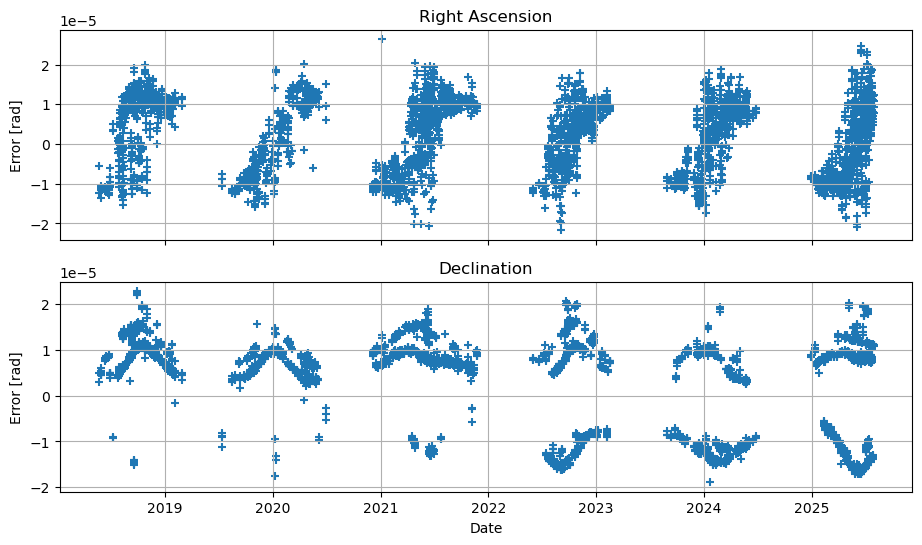

In [9]:
# Let's simplify by using only 329 Svea and removing observations from space telescopes
target = "329"
target_horizons = target + ";" # ; specifies minor bodies

batch_eros = BatchMPC()
batch_eros.get_observations([target])
batch_eros.filter(
    epoch_start=datetime(2018, 1, 1),
    observatories_exclude=["C51", "C57", "C59"],
)

# Retrieve MPC observation times, RA and DEC
batch_times = batch_eros.table.epochJ2000secondsTDB.to_list()
batch_times_utc = batch_eros.table.epochUTC.to_list()
batch_RA = batch_eros.table.RA
batch_DEC = batch_eros.table.DEC

# Create Horizons query, see Horizons Documentation for more info.
hypatia_horizons_query = HorizonsQuery(
    query_id=target_horizons,
    location="500@399",  # geocenter @ Earth
    epoch_list=batch_times,
    extended_query=True,
)

# retrieve JPL observations
jpl_observations = hypatia_horizons_query.interpolated_observations()
jpl_RA = jpl_observations[:, 1]
jpl_DEC = jpl_observations[:, 2]

max_diff_RA = np.abs(jpl_RA - batch_RA).max()
max_diff_DEC = np.abs(jpl_DEC - batch_DEC).max()
print("Maximum difference between Interpolated Horizons data and MPC observations:")
print(f"Right Ascension: {np.round(max_diff_RA, 10)} rad")
print(f"Declination: {np.round(max_diff_DEC, 10)} rad")

# create plot
fig, (ax_ra, ax_dec) = plt.subplots(2, 1, figsize=(11, 6), sharex=True)

ax_ra.scatter(batch_times_utc, (jpl_RA - batch_RA), marker="+")
ax_dec.scatter(batch_times_utc, (jpl_DEC - batch_DEC), marker="+")

ax_ra.set_ylabel("Error [rad]")
ax_dec.set_ylabel("Error [rad]")
ax_dec.set_xlabel("Date")

ax_ra.grid()
ax_dec.grid()

ax_ra.set_title("Right Ascension")
ax_dec.set_title("Declination")

plt.show()

That's it! Next, check out the [Estimation with MPC](estimation_with_mpc.ipynb) example to try estimation with the observations we have retrieved here. The remainder of the example discusses additional features of the BatchMPC interface.

## Additional Features

### Using satellite observations.
Space Telescopes in Tudat are treated as bodies instead of stations. To use their observations, their motion should be known to Tudat. A user may for example retrieve their ephemerides from a SPICE kernel or propagate the satellite. This body must then be linked to the MPC code for that space telescope when calling the `to_tudat()` method. The MPC code for TESS can be obtained using the `observatories_table()` method as used previously. Bellow is an example using a spice kernel.

In [10]:
# Note that we are using the add_empty_settings() method instead of add_empty_body().
# This allows us to add ephemeris settings, 
# which tudat uses to create an ephemeris which is consistent with the rest of the environment.
TESS_code = "-95"
body_settings.add_empty_settings("TESS")

# Set up the space telescope's dynamics, TESS orbits earth
# the spice kernel can be retrieved from: https://archive.stsci.edu/missions/tess/models/
spice.load_kernel(r"tess_20_year_long_predictive.bsp")
body_settings.get("TESS").ephemeris_settings =  environment_setup.ephemeris.direct_spice(
     "Earth", global_frame_orientation, TESS_code)

# NOTE this is incorrect, here we are trying to set the ephemeris directly:
# Setting the ephemeris settings allows tudat to complete the relevant setup for the body. 
# bodies.create_empty_body("TESS")
# bodies.get("TESS").ephemeris = environment_setup.ephemeris.direct_spice(
#      global_frame_origin, global_frame_orientation, TESS_code)

# Create system of bodies
bodies = environment_setup.create_system_of_bodies(body_settings)
# create dictionary to link names. MPCcode:NameInTudat
sats_dict = {"C57":"TESS"}

observation_collection = batch1.to_tudat(bodies, included_satellites=sats_dict, apply_star_catalog_debias = False)

### Manual retrieval from astroquery
Those familiar with astroquery (or those who have existing filtering/ retrieval processes) may use the `from_astropy()` and `from_pandas()` methods to still use `to_tudat()` functionality. The input must meet some requirements which can be found in the API documentation, the default format from astroquery fits these requirements.

In [11]:
mpc_code_hypatia = 238
data = MPC.get_observations(mpc_code_hypatia)

# ...
# Any additional filtering steps
# ...

batch2 = BatchMPC()
batch2.from_astropy(data)

# alternative if pandas is preferred:
# data_pandas = data.to_pandas()
# batch2.from_astropy(data_pandas)

batch2.summary()


   Batch Summary:
1. Batch includes 1 minor planets:
   ['238']
2. Batch includes 5137 observations, including 279 observations from space telescopes
3. The observations range from 1892-03-18 22:48:06.047982 to 2025-06-04 23:14:37.017586
   In seconds TDB since J2000: -3401442681.766395 to 802350946.2024047
   In Julian Days: 2412176.45007 to 2460831.468484
4. The batch contains observations from 110 observatories, including 2 space telescopes



### Combining batches

Batches can be combined using the `+` operator, duplicates are removed.

In [12]:
batch3 = batch2 + batch1
batch3.summary()


   Batch Summary:
1. Batch includes 3 minor planets:
   ['238', '433', '329']
2. Batch includes 10684 observations, including 2138 observations from space telescopes
3. The observations range from 1892-03-18 22:48:06.047982 to 2025-06-04 23:14:37.017586
   In seconds TDB since J2000: -3401442681.766395 to 802350946.2024047
   In Julian Days: 2412176.45007 to 2460831.468484
4. The batch contains observations from 159 observatories, including 3 space telescopes



### Copying and non in-place filtering
We may want to compare results between batches. In that case it is useful to copy a batch or perform non-destructive filtering:

In [13]:
# Copying existing batches:
import copy
batch1_copy = copy.copy(batch1)
# simpler equivalent:
batch1_copy = batch1.copy()

# normal in-place/destructive filter
batch1_copy.filter(epoch_start=datetime(2023, 1, 1)) # returns None
# non-destructive filter:
batch1_copy2 = batch1.filter(epoch_start=datetime(2023, 1, 1), in_place=False) # returns filtered copy

batch1_copy.summary()
batch1_copy2.summary()


   Batch Summary:
1. Batch includes 2 minor planets:
   ['433', '329']
2. Batch includes 378 observations, including 28 observations from space telescopes
3. The observations range from 2023-01-04 19:17:22.271984 to 2023-08-22 22:03:05.184015
   In seconds TDB since J2000: 726131911.4559577 to 746013854.3668225
   In Julian Days: 2459949.30373 to 2460179.41881
4. The batch contains observations from 20 observatories, including 1 space telescopes


   Batch Summary:
1. Batch includes 2 minor planets:
   ['433', '329']
2. Batch includes 378 observations, including 28 observations from space telescopes
3. The observations range from 2023-01-04 19:17:22.271984 to 2023-08-22 22:03:05.184015
   In seconds TDB since J2000: 726131911.4559577 to 746013854.3668225
   In Julian Days: 2459949.30373 to 2460179.41881
4. The batch contains observations from 20 observatories, including 1 space telescopes



### Plotting observations
The `.plot_observations_sky()` method can be used to view a projection of the observations. Similarly, `.plot_observations_temporal()` shows the declination and right ascension of a batch's bodies over time.

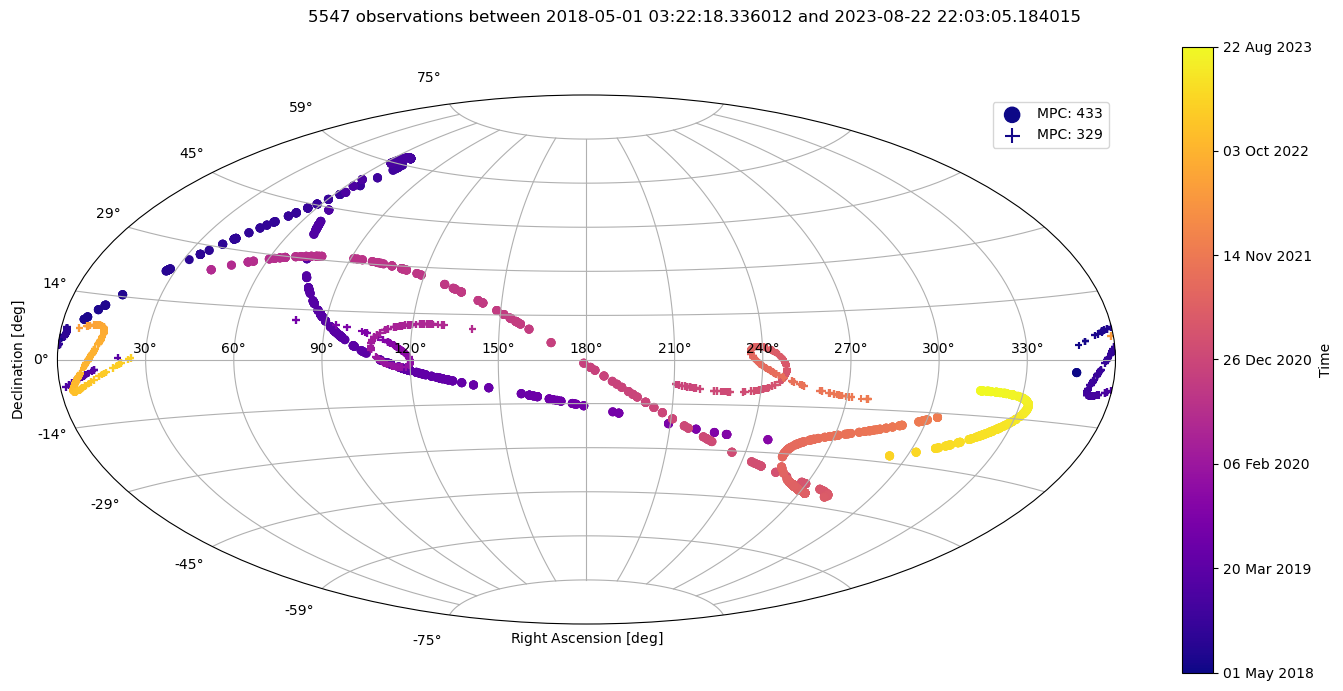

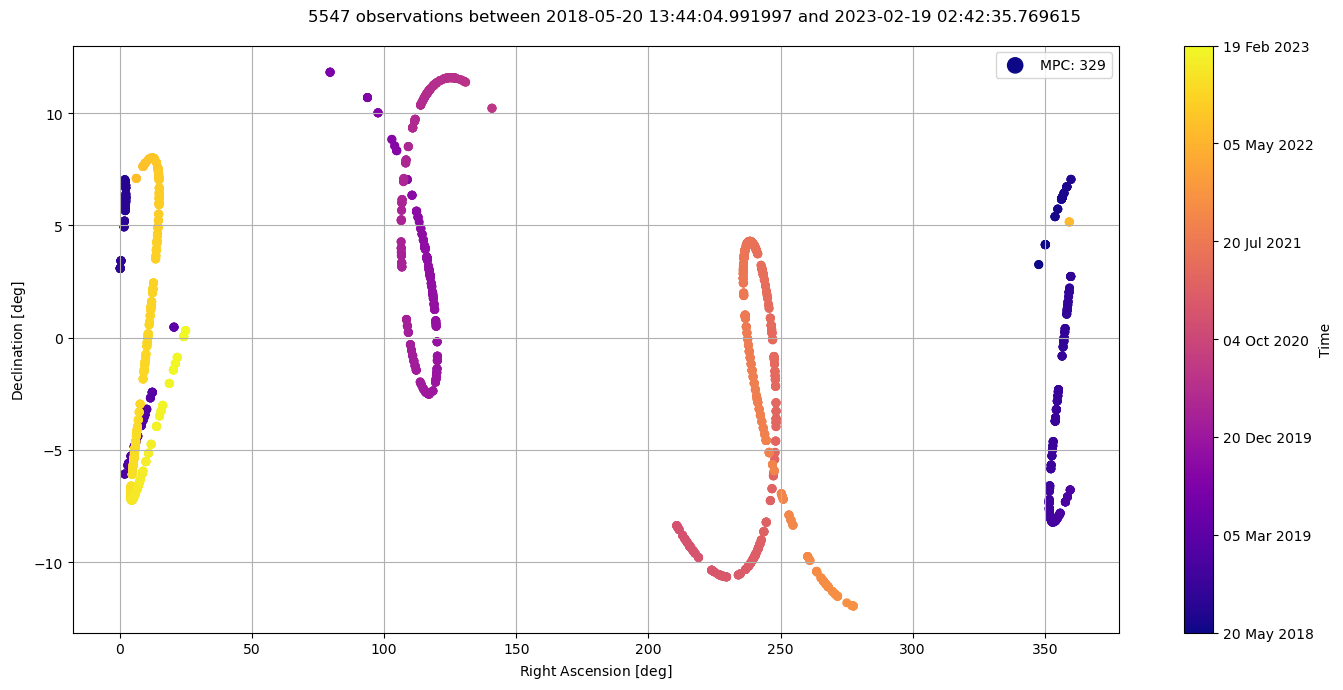

In [14]:
# Try some of the other projections: 'hammer', 'mollweide' and 'lambert'
fig = batch1.plot_observations_sky(projection="aitoff")
# specific objects can be selected for large batches:
fig = batch1.plot_observations_sky(projection=None, objects=[329]) 

plt.show()

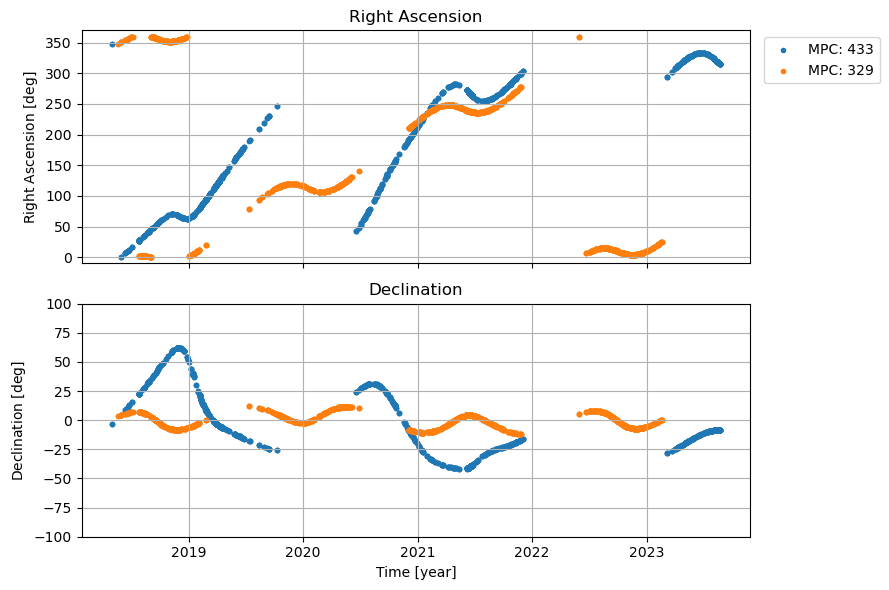

In [15]:
# Similar to the sky plot, specific bodies can be chosen to be plotted with the objects argument
fig = batch1.plot_observations_temporal()

plt.show()